

# [동양여우](https://lucid.app/lucidchart/a4d5d8f8-5fe2-4aa3-9008-362a3953977a/edit?viewport_loc=-85%2C258%2C2037%2C742%2C0_0&invitationId=inv_59510ea0-c965-4482-a821-88b71505b936#) ver 0.0.1
![alt text](resource/fox.png "Title")

### 시가총액 기준 분위수 분석
* 어떤 한 시점에 상장된 주식들의 지난 몇년간의 기준 (e.g., 시가총액)을 전부 크기에 따라 줄 세울수 있습니다 ✨
* 네개의 구간으로 나누어 생각해볼까요? 예를 들어 상위 25%, 그 및 25% ... 최하위 25% 이렇게요.

In [16]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from core.constants import TableKey
from core.strategy import Selector, SelectorType, SelectorSequence, Filter

target_key = TableKey.FinancialRatios.Quarter.PER # 배당 / 순이익 / 시총 등 테스트

n_division = 4
lookback_year = 1

filter_list = []
relative_range_list = [(i / n_division, (i + 1) / n_division) for i in range(n_division)]
relative_range_list.append((0.0, 1.0))

for relative_value_range in relative_range_list:
    filter_name = target_key + '=(' + str(relative_value_range[0]) + '-' + str(relative_value_range[1]) + ')'
    relative_selector = Selector(type=SelectorType.HORIZON_RANGE, key=target_key, value=relative_value_range,
                                 horizon=lookback_year,
                                 is_absolute=False)
    selector_sequence = SelectorSequence(selectors=[relative_selector])
    filter_list.append(Filter(selector_sequence_union=[selector_sequence], name=filter_name))

KeyboardInterrupt: 

### 투자 시뮬레이션 준비
* 자! 그럼 이제 **주어진 기간동안** (e.g., 1960년 ~ 2022년) 까지 일정한 주기로 (e.g., 3개월마다) 주식들을 골라서 갖고 있어보아요
* 고를때 A 라는 사람은 시가총액 상위 20% 만 B 라는 전략가는 상위 20%-40% 만 .. E 라는 사람은 하위 20 % 만 꾸준히 산다고 가정해볼게요.
* 일단 전체 모집단은 [NYSE, NASDAQ, ...? ]의 주식으로 해볼게요! (시간 관계상, 거래소 주식의 일부분만 대상으로 할게요)

In [3]:
from datetime import date
from core.db_interface import DataBaseInterface
from core.strategy import Strategist
import pandas as pd
from tqdm import tqdm

db_interface = DataBaseInterface()

exchange_pool = ['NASDAQ']
horizon = (date(2010, 1, 1), date(2022, 8, 22)) # 2021 년부터 테스트 해보기 !
freq = '6M'

initial_symbols = db_interface.get_stock_on_exchange(exchange_pool)
rebalance_dates = pd.date_range(horizon[0], horizon[1], freq=freq, inclusive='both')
strategist_list = []

tqdm_object = tqdm(total=len(filter_list) * len(rebalance_dates))
tqdm_object.set_description(f"동양여우가 {len(initial_symbols)}개의 주식 중에서 고르는 중 ")

with tqdm_object as pbar:
    for filter_ in filter_list:
        strategist_name = filter_.name
        strategist = Strategist(fetcher=db_interface, name=strategist_name, asset_pool=initial_symbols,
                                start_date=horizon[0], end_date=horizon[1])
        for rebalance_date in rebalance_dates:
            strategist.apply_filter(filter_in=filter_, date_in=rebalance_date.date())
            pbar.update(1)
        strategist_list.append(strategist)

print("다 되었어요!")

동양여우가 1442개의 주식 중에서 고르는 중 : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:08<00:00, 15.09it/s][00:00<?, ?it/s]

다 되었어요!


## 자, 그럼 우리가 여태 고른 주식들은 어떤 종목들이었는지 살펴볼까요? 😍
### 우선 한번 크게 봐볼까요?
* 각 전략별로 통 기간동안 고른 주식들의 섹터별 통계를 한번 봐볼게요.
* 맨 마지막 파이는 전제 대상 주식의 분포에요.

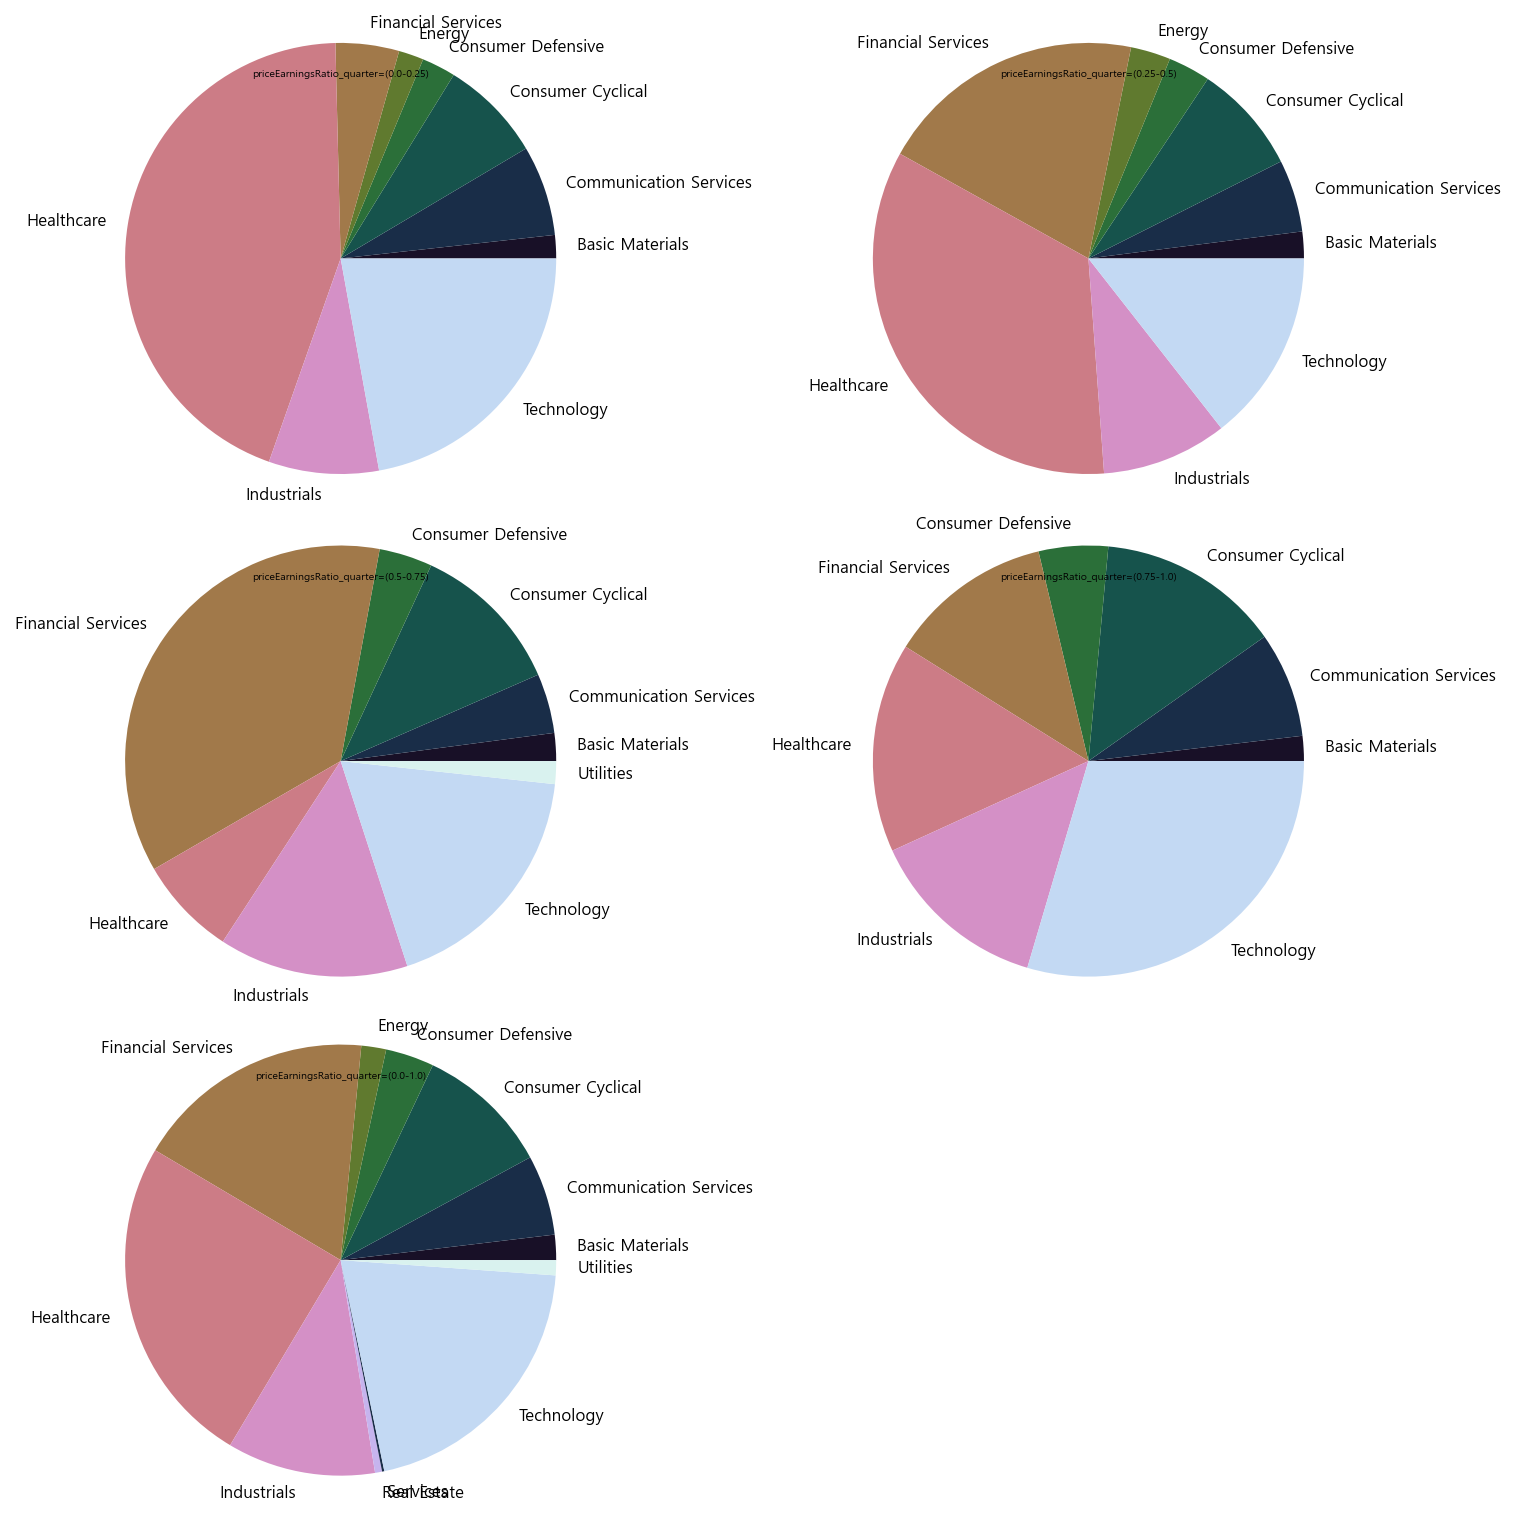

In [11]:
from core.evaluate import show_selection, prepare_canvas
import matplotlib.pyplot as plt
import math

prepare_canvas(fontsize=8)
for idx, strategist in enumerate(strategist_list):
    plt.subplot(math.ceil(len(strategist_list) / 2), 2, idx + 1)
    show_selection(strategist, db_interface, radius=1.5, fontsize=5, labeldistacne=1.1, titlepad=-200)

# 자, 그럼이제 우리 각 전략들을 고수했을때 우리 잔고는 어떻게 되었는지 생각해볼까요?
* 처음 잔고를 1원이라고 가정해볼게요. 과연 이 기간동안 최종 잔고는 어떻게 되었을까요? 🤔
* 첫번째 그림이 각 전략을 계속 고수했을 때 잔고 상태입니다.

In [12]:
from core.evaluate import get_all_symbols_price_history

df_all_price_history = get_all_symbols_price_history(strategist_list[-1], db_interface)
df_all_price_history = df_all_price_history.resample('6D').mean()

1432 / 1433 종목이 유효한 가격 히스토리를 가지고 있습니다.


,priceEarningsRatio_quarter=(0.0-0.25),priceEarningsRatio_quarter=(0.25-0.5),priceEarningsRatio_quarter=(0.5-0.75),priceEarningsRatio_quarter=(0.75-1.0),priceEarningsRatio_quarter=(0.0-1.0)
최종 수익률,329,780,456,463,500
최대하락폭,-47,-49,-41,-29,-29
오른 달 비율,60,62,63,68,65


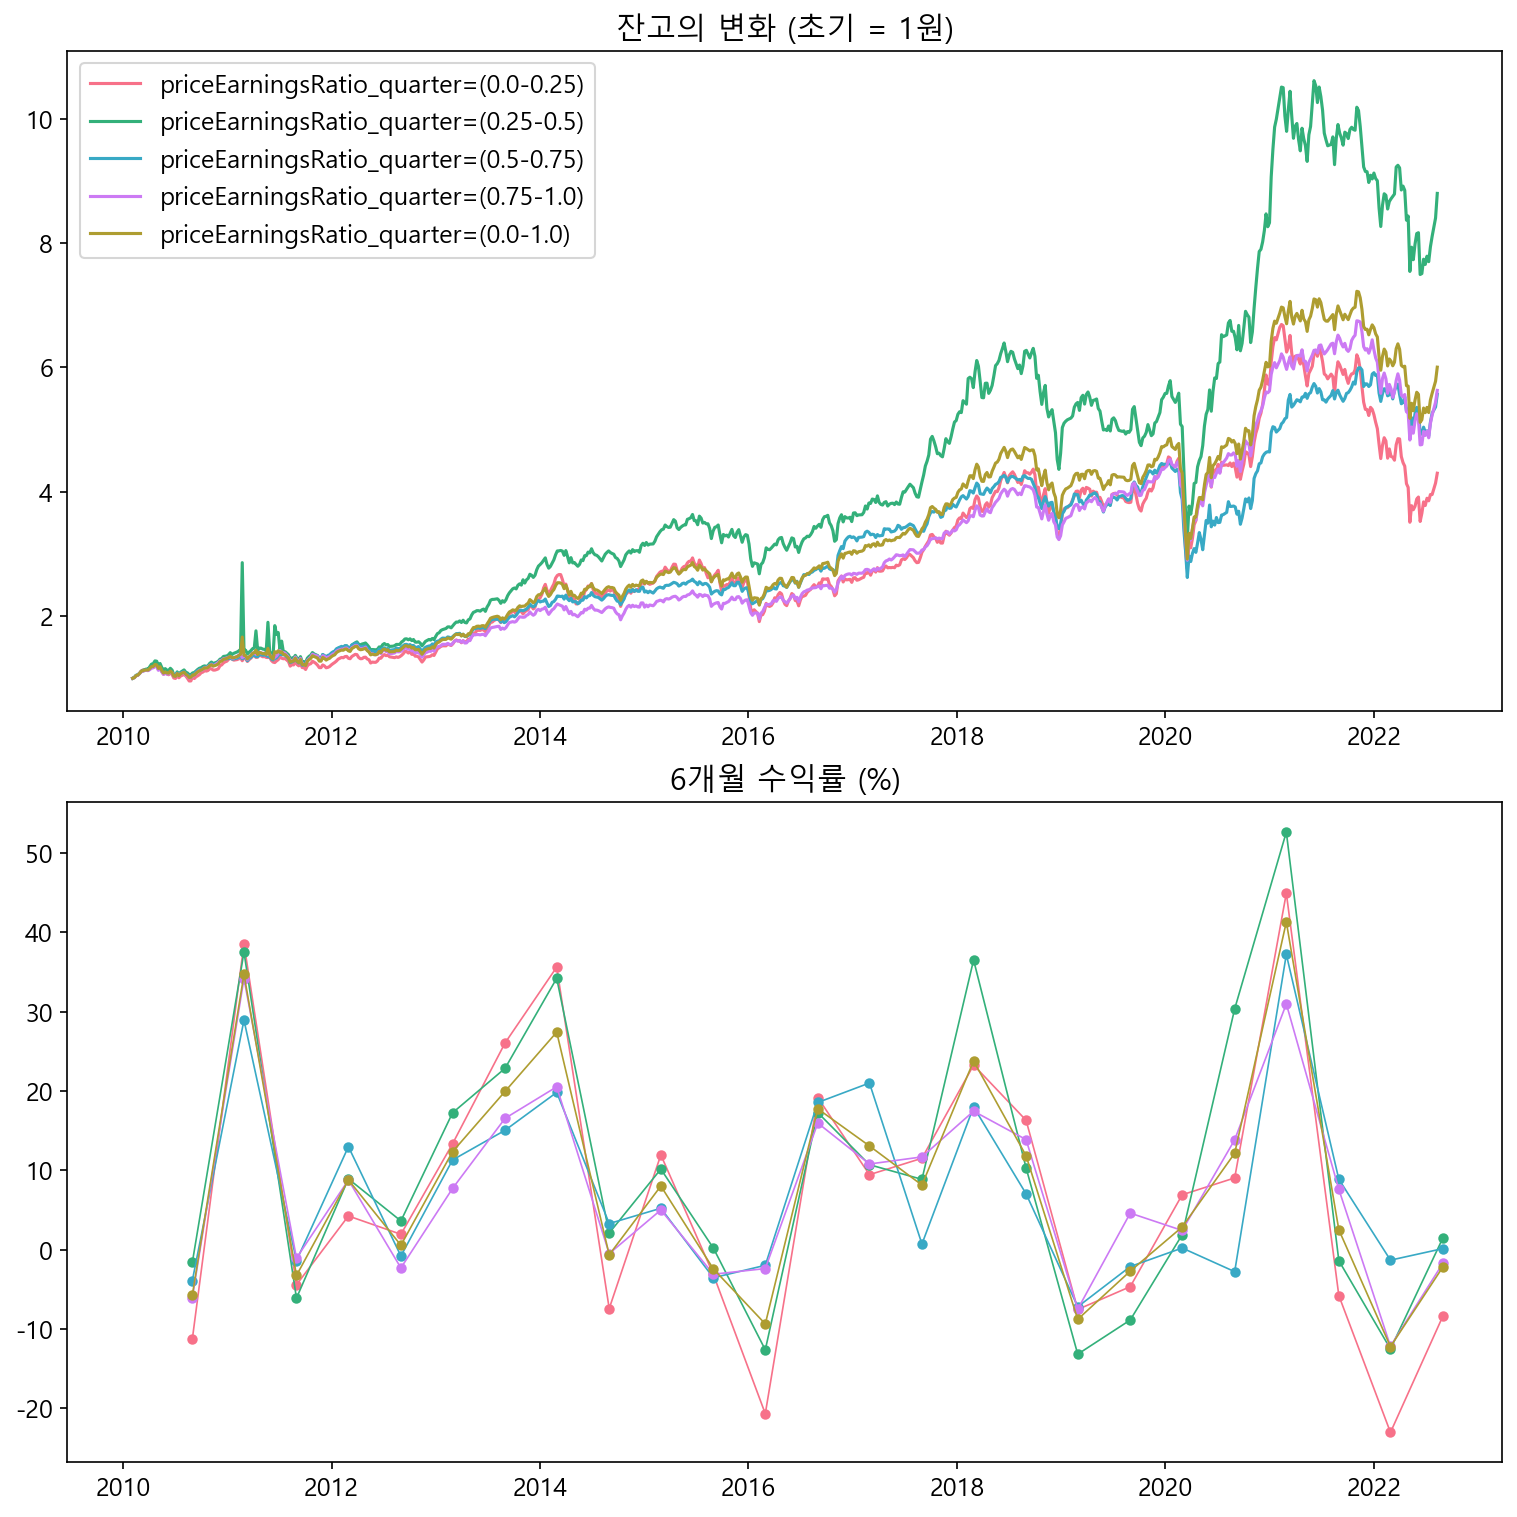

In [13]:
from core.evaluate import show_comparative_report
show_comparative_report(strategist_list, df_all_price_history)

### 다음은, 각 전략별로 기간동안 무엇을 했는지 봐볼게요.
* 우리는 기간마다 전부 팔고, 다시 기준에 부합하는 주식을 새로 고르기 때문에 (rebalancing) 전략은 같아도 선택되는 주식은 늘 변할 거에요 !
* 왜냐면, 시가 총액 / PBR / PER 등등 매일 혹은 매 분기마다 변하는 것이니까요.

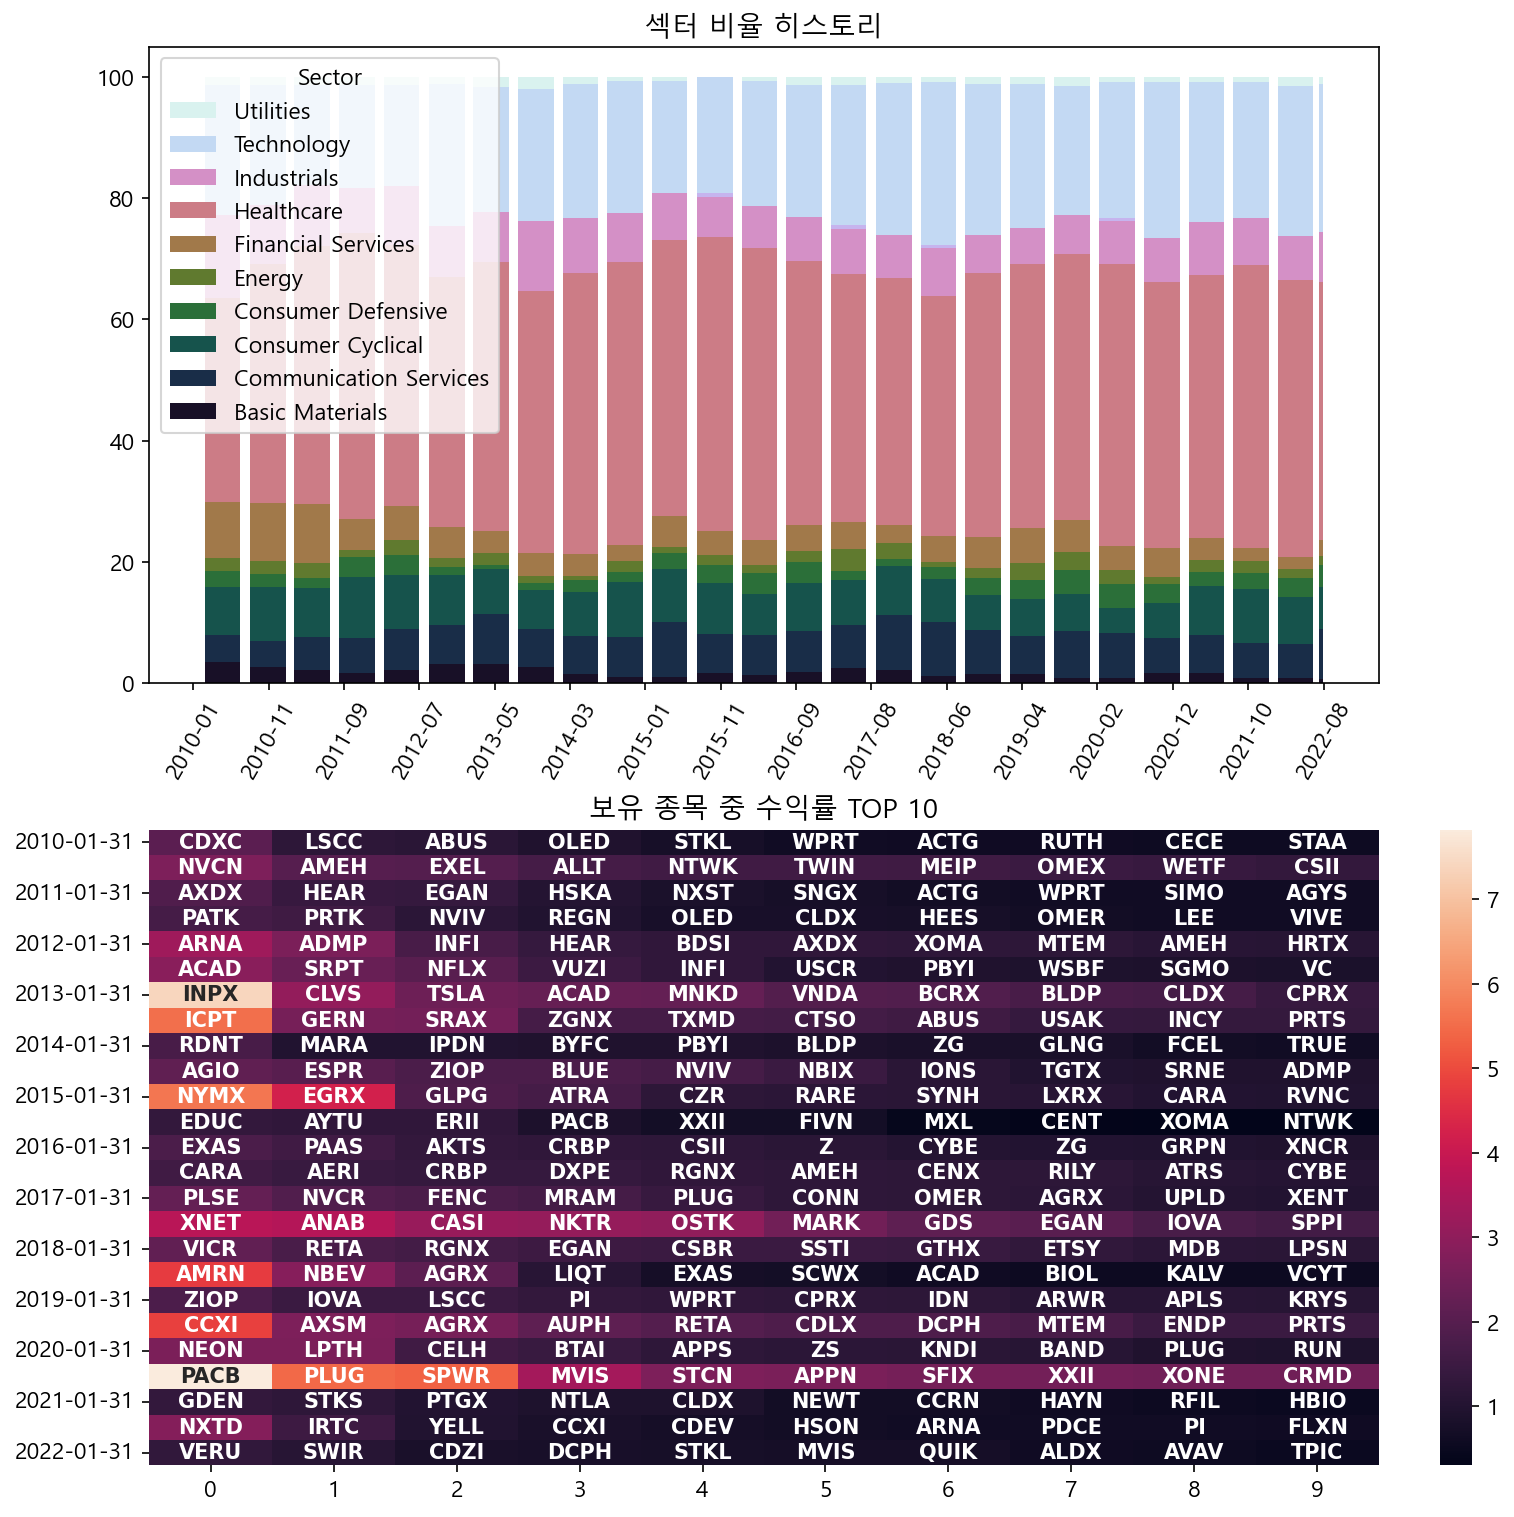

In [14]:
from core.evaluate import show_sector_distribution_history, analyze_leaders, prepare_canvas
import matplotlib.pyplot as plt
strategist = strategist_list[0]
prepare_canvas(fontsize=11)
plt.subplot(2, 1, 1)
plt.title('섹터 비율 히스토리')
show_sector_distribution_history(strategist, db_interface)
plt.subplot(2, 1, 2)
plt.title('보유 종목 중 수익률 TOP 10')
df_leader_symbol, df_leader_return_ration =  analyze_leaders(strategist, df_all_price_history, True, {
            'fontsize': 10,
            'fontweight': 'bold',
            'fontfamily': 'sans'
        })